<a href="https://colab.research.google.com/github/guiguilhermegui/TF/blob/main/modelo_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checkout www.pygimli.org for more examples
#!pip install pygimli tetgen


# Hydrogeophysical modelling

Coupled hydrogeophysical modelling example. This essentially represents the
forward modelling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


Create geometry definition for the modelling domain



In [17]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

In [41]:
# Parametros dos furos
bores = [-20, -15, -10, -5, 0, 5, 10, 15]                       # Posição central dos furos
altura_poco=0
prof_poco=-0.9
raio_poco=0.35              #precisa ser decimal "3.00001"

K_poco = 1e12
K_mundo=178

# Posicoes relativas do furo
esq = '.' + f'{raio_poco:.2f}'.split('.')[1]
dir = '.' + f'{1 - raio_poco:.2f}'.split('.')[1]
#print(f'raio_poco={raio_poco:.2f} esq={esq} dir={dir}')

#limites world sandbox
box_esq=-30
box_dir=30
box_top=0.01
box_bottom=-20

#parâmetros de malha
mesh_area=0.3               # area da mesh em metros^2
mesh_quality=33             # qualidade da mesh evitar valores acima de 33 por questões de performance

# Defina os parâmetros iniciais hidráulicos
taxa_de_infiltracao = 0.005 # Taxa de infiltração em m/s
num_iteracoes = 20          # Número de iterações dt para simulação
dt = 1                      # Intervalo de tempo em segundos

# Parâmetros do meio poroso para adveccao-dispersao
phi = 0.3                   # Porosidade meio
D = 0.01                    # Coeficiente de dispersão m^2/s


#Definições de variáveis e funções
h0 = altura_poco            # Altura inicial da água no poço
h2o = h0 - prof_poco        # Altura da linha da água inicial no poço
#h2o2=0
#y=0.0001
#y = 0.1  # Defina a variação na linha vertical da fronteira
coord = []




#sigmaFluid                 # Condutividade elétrica da água em S/m
sigma_a = 0.1
sigma_b = 0.01

cementation_exponent = 1.3, # Exponente de cimentação para a resistividade do solo

#ERT

ERT_dist= 600                # Distância entre os eletrodos em metros
ERT_elecs = 60             # Espaçamento entre os eletrodos em metros
ERT_2 = ERT_dist/2
ERT_spac = 10
ERT_Array = 'dd'
elecs = np.linspace(-ERT_2, ERT_2, ERT_elecs)




TimeSimu_days = 6         # Tempo de simulação em dias  
TimeSimu_slice = 800               # Número de fatias para a simulação em time steps

coord[[0, -21.0, 0.01], [1, -21.0, -10.0], [2, 16.0, -10.0], [3, 16.0, 0.01]]
coord[[4, -20.35, 0.0], [5, -20.35, -0.9], [6, -19.65, -0.9], [7, -19.65, 0.0]]
coord[[8, -15.35, 0.0], [9, -15.35, -0.9], [10, -14.65, -0.9], [11, -14.65, 0.0]]
coord[[12, -10.35, 0.0], [13, -10.35, -0.9], [14, -9.65, -0.9], [15, -9.65, 0.0]]
coord[[16, -5.35, 0.0], [17, -5.35, -0.9], [18, -4.65, -0.9], [19, -4.65, 0.0]]
coord[[20, -0.35, 0.0], [21, -0.35, -0.9], [22, 0.35, -0.9], [23, 0.35, 0.0]]
coord[[24, 4.65, 0.0], [25, 4.65, -0.9], [26, 5.35, -0.9], [27, 5.35, 0.0]]
coord[[28, 9.65, 0.0], [29, 9.65, -0.9], [30, 10.35, -0.9], [31, 10.35, 0.0]]
coord[[32, 14.65, 0.0], [33, 14.65, -0.9], [34, 15.35, -0.9], [35, 15.35, 0.0]]


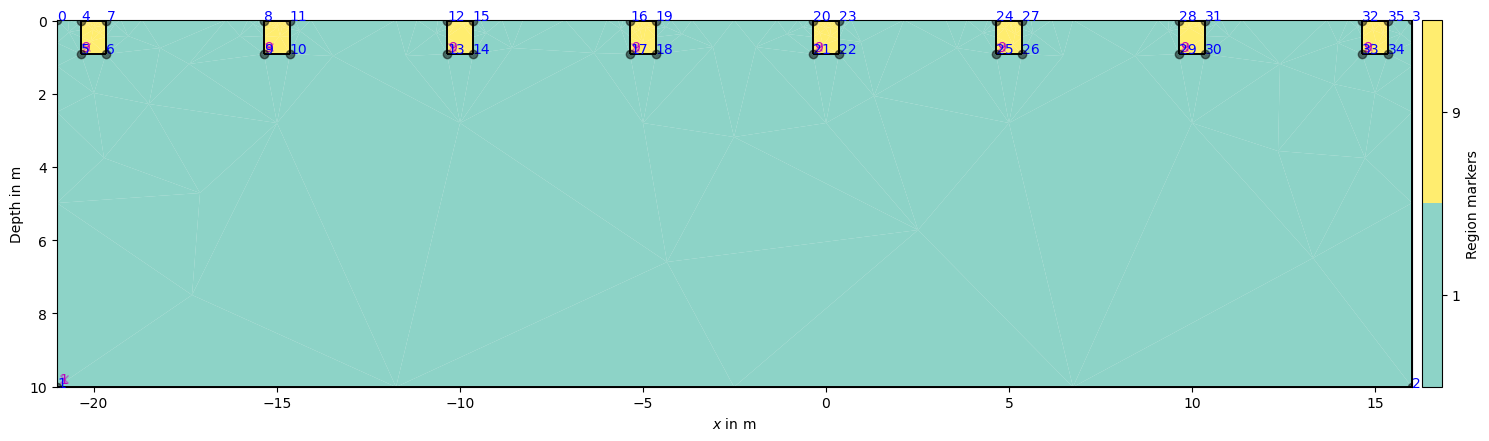

In [43]:
# Create a 2D world box
world = mt.createWorld(start=[box_esq, box_top], end=[box_dir, box_bottom], WorldMarker=True,) #layers=[-2,-8]) 

# Create boreholes
poco = []
for pos in bores:
    poco.append(mt.createRectangle(start=[pos - raio_poco, altura_poco], end=[pos + raio_poco,prof_poco], marker=9))
boreholes = poco[0]
for borehole in poco[1:]:
    boreholes = boreholes + borehole


# Create geometry of model
geom = world + boreholes
mesh = mt.createMesh(geom, quality=mesh_quality, area=mesh_area, smooth=[1, 10])
#pg.show(mesh)

#Create figure
ax, _ = pg.show(geom, markers=False, orientation='vertical', figsize=(15, 8), showNodes=True, showMesh=True)
# Print nodes
for i, n in enumerate(geom.nodes()):
    ax.text(n.x(), n.y(), str(i), color='blue', size=10)
    coord.append([i, n.x(), n.y()])
# Print 4 lists of nodes per line, very useful for rectangles
for i in range(0, len(coord), 4):
    print('coord' + str(coord[i:i+4]))

In [30]:
#Calculo doido de coordenadas dos nós
leftneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(esq))]
leftpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(dir))]
rightpos_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] > 0 and str(boundary.center()[0]).endswith(esq))]
rightneg_boundaries = [boundary.id() for boundary in geom.boundaries() if (boundary.center()[0] < 0 and str(boundary.center()[0]).endswith(dir))]
left_boundaries = leftneg_boundaries + leftpos_boundaries
right_boundaries = rightneg_boundaries + rightpos_boundaries

top_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] == altura_poco]
bottom_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] ==prof_poco]
world_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.id() not in top_boundaries + bottom_boundaries + left_boundaries + right_boundaries]
print('left_boundaries: ' + str(left_boundaries))
print('bottom_boundaries: ' + str(bottom_boundaries))
print('right_boundaries: ' + str(right_boundaries))
print('top_boundaries: ' + str(top_boundaries))
print('world_boundaries: ' + str(world_boundaries))



left_boundaries: [4, 8, 12, 16, 20, 24, 28, 32]
bottom_boundaries: [5, 9, 13, 17, 21, 25, 29, 33]
right_boundaries: [6, 10, 14, 18, 22, 26, 30, 34]
top_boundaries: [7, 11, 15, 19, 23, 27, 31, 35]
world_boundaries: [0, 1, 2, 3]


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

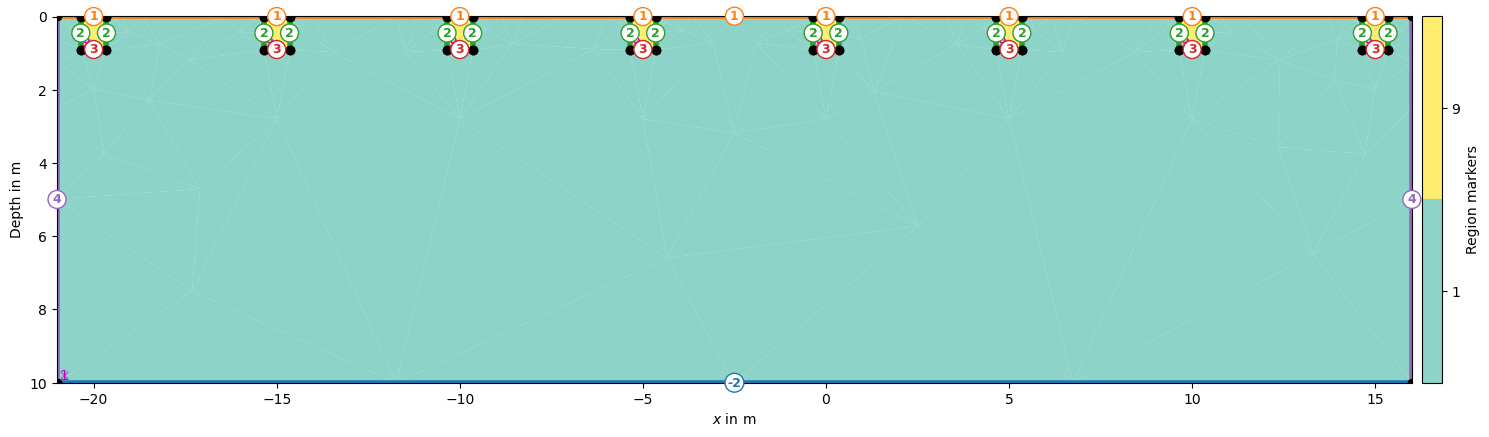

In [44]:
# Atribuição da numeracao das fronteiras
#fronteiras boreholes
def pos(count):
    return pg.Pos(coord[count][1], coord[count][2])

for a in range(len(bottom_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=3)

for a in range(len(right_boundaries)):
    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=2)

for a in range(len(left_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=2)

#fronteiras world

geom.createEdge(geom.node(0), geom.node(1), marker= 4)
geom.createEdge(geom.node(1), geom.node(2), marker=-2)
geom.createEdge(geom.node(2), geom.node(3), marker= 4)
geom.createEdge(geom.node(3), geom.node(0), marker= 1)

pg.show(geom, label='Boundary marker', markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}K^{-1}\mathbf{v} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x14780d181f0>)

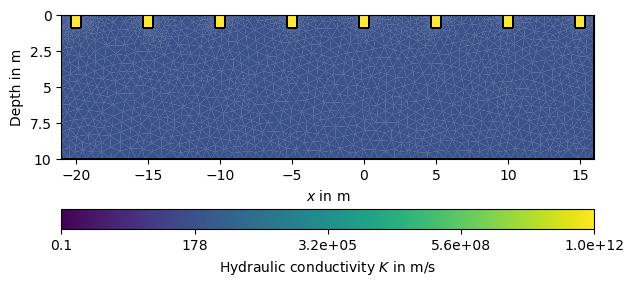

In [46]:
# Atribute hydraulic conductivity in m/s to each region (interfaces/layers) of the model
kMap = [[1, K_mundo],  [9, K_poco]] #[0, 3e-1],    #Use [[RegionMarker, ConductivityValue], ...]

# Map conductivity value per region to each cell in the given mesh
K = pg.solver.parseMapToCellArray(kMap, mesh)

pg.show(mesh, data=K, label='Hydraulic conductivity $K$ in m/s', cMin=1e-1, cMax=1e12, logScale=True, grid=True)

The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



In [53]:
# Dirichlet conditions for hydraulic potential
topo = 0.9
base = 0.0
pBound = {"Dirichlet": {-2: base, 1: topo}}

Mesh:  Mesh: Nodes: 4302 Cells: 7940 Boundaries: 12241
Assembling time:  0.0529569
Solving time:  0.0106475
Mean: 0.7497441095247862, Std: 0.2694520470050599, Min: 0.0, Max: 0.9000000000000936


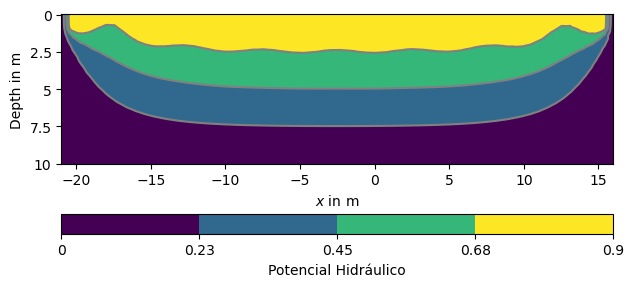

In [55]:
parcial = 10
mostrar_parcial = False
mostrar_cada_iteracao = False

#Resolver pra pBound
#p = np.random.rand(mesh.cellCount())                   # Inicialize com potencial hidráulico aleatorio

# Inicialize o dicionário de condições de fronteira pBound
#pBound = { "Neumann": {},"Dirichlet": {}}
#pBound = { "Neumann": {}}
#pBound = { "Dirichlet": {}}
#Loop para simular o preenchimento e esvaziamento do poço

# Resolver o modelo de potencial hidráulico
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound, verbose=True)
# Calcular a nova altura do poço com base na taxa de esvaziamento
#h2o = h0 - prof_poco - taxa_de_infiltracao * dt
# Garantir que a altura do poço não fique negativa


#    if mostrar_cada_iteracao == True:
#        pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))
#    if mostrar_parcial == True:
#        if t % parcial == 0:
#            pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))

pg.show(mesh, data=p, label='Potencial Hidráulico')
#pg.show(mesh, data=p, label='Potencial Hidráulico após iteração {}'.format(t))
#print(pBound)
#print(h2o)

# Calculate statistics
mean_p = np.mean(p)
std_p = np.std(p)
min_p = np.min(p)
max_p = np.max(p)

print(f"Mean: {mean_p}, Std: {std_p}, Min: {min_p}, Max: {max_p}")


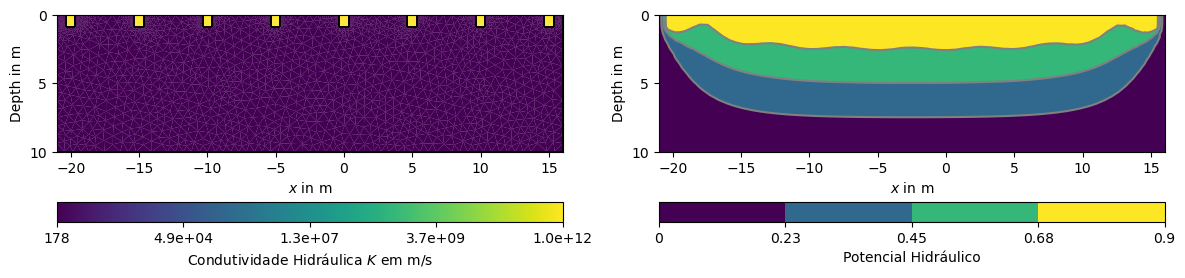

In [56]:
# Atualizar a visualização ou armazenar resultados
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
pg.show(mesh, data=K, label='Condutividade Hidráulica $K$ em m/s', logScale=True, grid=True, ax=axs[0])
pg.show(mesh, data=p, label='Potencial Hidráulico', cMin=min_p, cMax=max_p, ax=axs[1])
plt.show()

# (Opcional) Adicionar uma pausa para visualização
# plt.pause(0.1)  # Se você estiver usando matplotlib para visualização

We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



Mean Velocity: -1.8601981929621427, Std: 26.106521938127834, Min: -367.796365234945, Max: 298.0958660579819


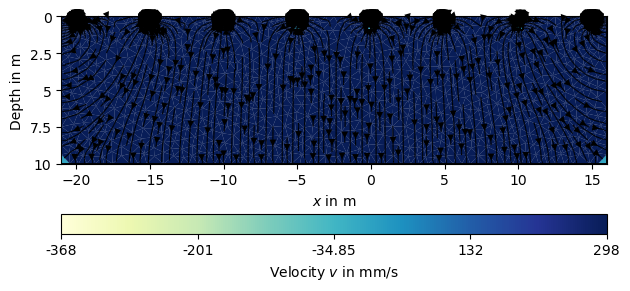

In [57]:
# Solve velocity as gradient of hydraulic potential
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T

# Calculate statistics for the new range
mean_vel = np.mean(vel)
std_vel = np.std(vel)
min_vel = np.min(vel)
max_vel = np.max(vel)

print(f"Mean Velocity: {mean_vel}, Std: {std_vel}, Min: {min_vel}, Max: {max_vel}")

ax, _ = pg.show(mesh, data=pg.abs(vel) * 1000, cMin=min_vel, cMax=max_vel,
                label='Velocity $v$ in mm/s', cMap='YlGnBu', hold=True)
ax, _ = pg.show(mesh, data=vel, ax=ax, color='k', linewidth=0.8, dropTol=1e-5,
                hold=True)

In [58]:
# Initialize the source vector of injections
S = pg.Vector(mesh.cellCount(), 0.0)

# Fill injection source vector for a fixed injection position
for pos in bores:
    sourceCell = mesh.findCell(pos,0)
    if sourceCell:
        S[sourceCell.id()] += 1.0 / sourceCell.size()  # g/(l s)


08/01/25 - 20:10:12 - pyGIMLi - WARNING - Courant-Friedrichs-Lewy Number: 19524089.88970669 but should be lower 1 to ensure movement inside a cell per timestep. (vMax = 294.67831882420893 dt = 648.811013767209 dx = 0.009792545509245455 dt < 3.323130642362332e-05  | N >  19524090 )
c:\Users\gui\.conda\envs\pg\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
08/01/25 - 20:10:14 - pyGIMLi - WARNING - Courant-Friedrichs-Lewy Number: 19524089.88970669 but should be lower 1 to ensure movement inside a cell per timestep. (vMax = 294.67831882420893 dt = 648.811013767209 dx = 0.009792545509245455 dt < 3.323130642362332e-05  | N >  19524090 )


Mean: 10.634308268359348, Std: 10.90681819675351, Min: -0.6993297578846112, Max: 22.653786114912375


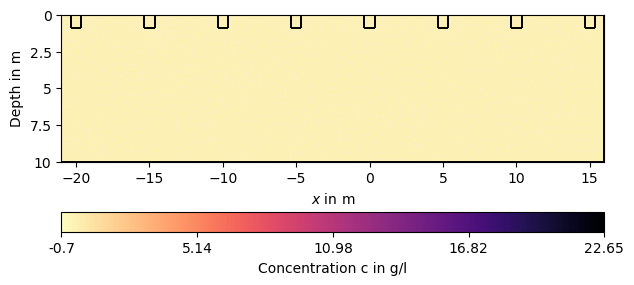

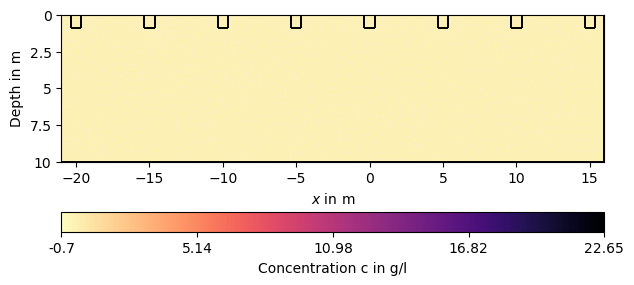

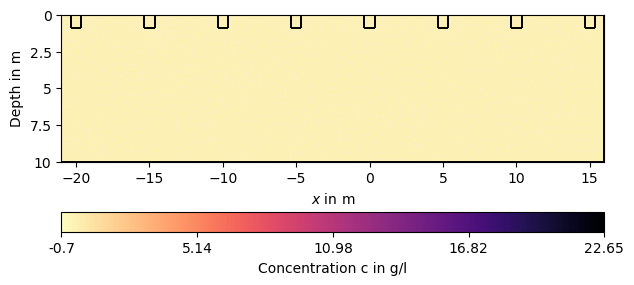

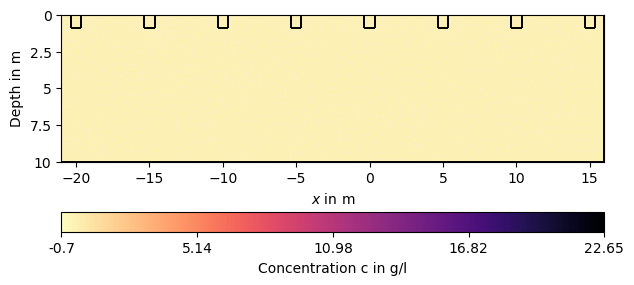

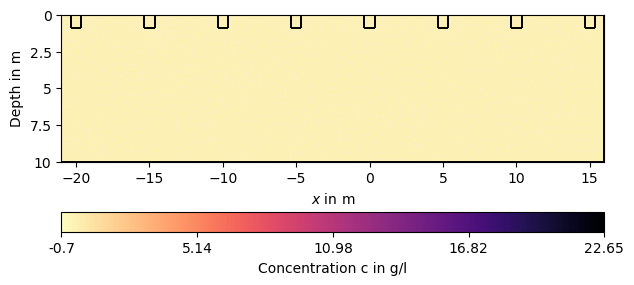

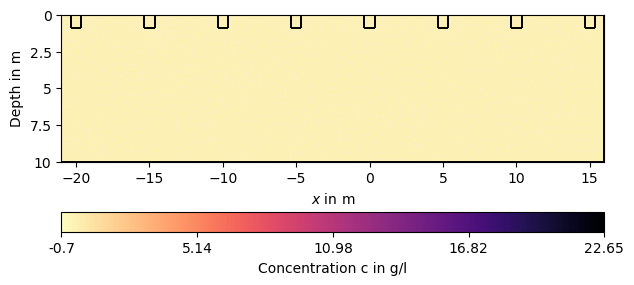

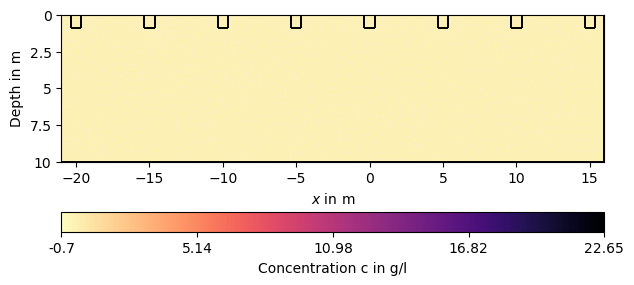

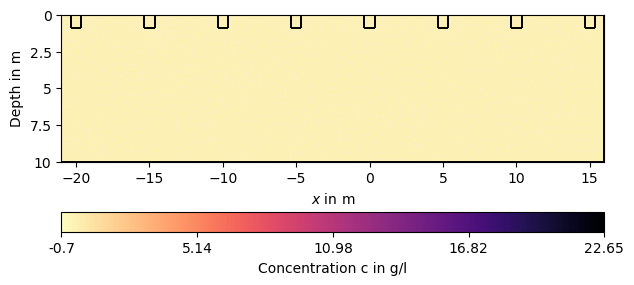

In [59]:
# Choose n slices  time steps for TimeSimulation days to seconds
t = pg.utils.grange(0, TimeSimu_days * 24 * 3600, n=TimeSimu_slice)

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e2

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=S, vel=veln, times=t,
                                 scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1],
                                 times=t, scheme='PS', verbose=0)
# Stack results together
c = np.vstack((c1, c2))

# We can now visualize the result:
# Calculate statistics
mean_c = np.mean(c)
std_c = np.std(c)
min_c = np.min(c)
max_c = np.max(c)

print(f"Mean: {mean_c}, Std: {std_c}, Min: {min_c}, Max: {max_c}")

# Visualize the result
for ci in c[1:][::200]:
    pg.show(mesh, data=ci * 0.001, cMin=min_c, cMax=max_c, cMap="magma_r",
            label="Concentration c in g/l")
    

Warning! DataSchemeBase::create has unhandled arguments
{'spacing': 10}


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

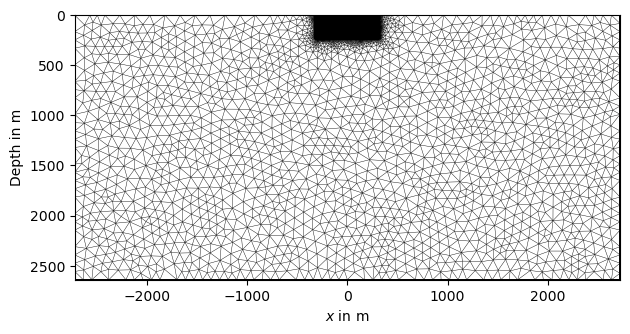

In [60]:
# Create ERT measurement scheme

ertScheme = ert.createData(elecs=elecs, schemeName=ERT_Array, spacing=ERT_spac)

meshERT = mt.createParaMesh(ertScheme, quality=mesh_quality, paraMaxCellSize=10, nLayers=3,
boundaryMaxCellSize=7500, smooth=[1, 2])

pg.show(meshERT)

In [61]:

timesERT = pg.IVector(np.floor(np.linspace(0, len(c) - 1, 10)).astype(int)) # Select 10 time frame to simulate ERT data

# Create conductivity of fluid for salt concentration :math:`c`
sigmaFluid = c[timesERT] * sigma_a + sigma_b

c = np.array(c)  # Ensure c is a numpy array

# Calculate bulk resistivity based on Archie's Law
resBulk = petro.resistivityArchie(rFluid=1. / sigmaFluid, porosity=phi, m=cementation_exponent,
                                  mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.
for cell in meshERT.cells():
    if cell.center()[1] < -8:
        rho0[cell.id()] = 150.
    elif cell.center()[1] < -2:
        rho0[cell.id()] = 500.
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)

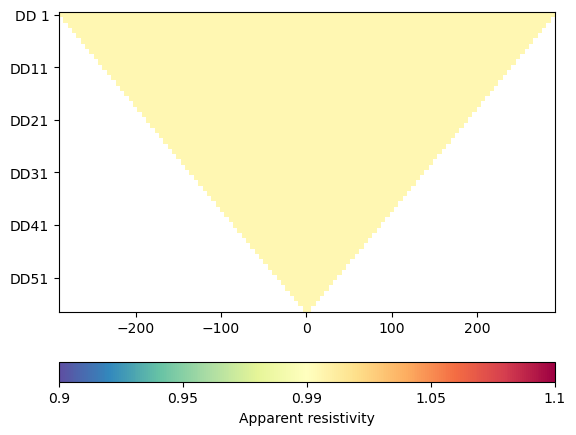

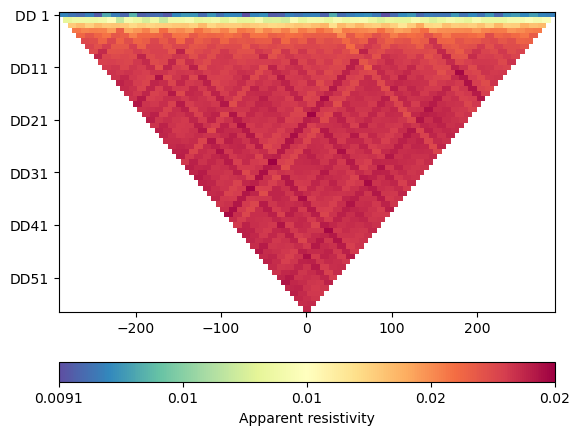

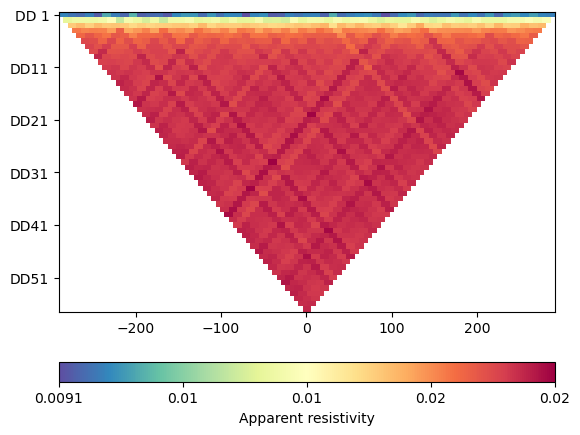

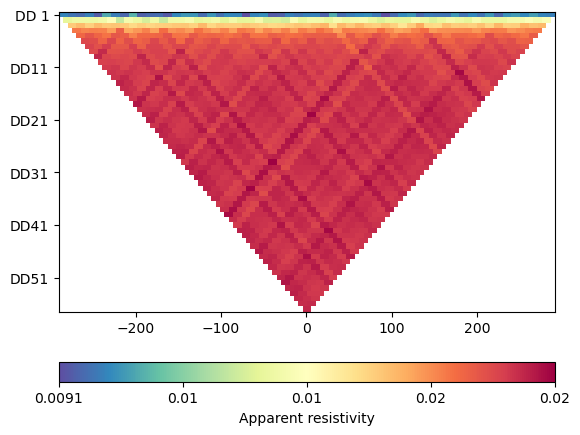

In [64]:
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0],logScale=True, label='Apparent resistivity',)